In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.cm as cm

from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib.colors import ListedColormap

In [2]:
plt.style.use('dark_background')

In [3]:
data = pd.read_csv('./KaDo.csv')

In [4]:
base_df = data.copy()

In [5]:
clientId = 1490281

# Clustering Client

In [6]:
df = base_df.filter(["PRIX_NET", "NB_ACHAT", "MAILLE", "CLI_ID"])
df["NB_ACHAT"] = 1

df.head()

,PRIX_NET,MAILLE,CLI_ID,NB_ACHAT
0,1.67,HYG_JDM,1490281,1
1,1.66,HYG_JDM,1490281,1
2,7.45,VIS_JEUNE_ET_LEVRE,1490281,1
3,5.95,VIS_AAAR_DEMAQLOTION,1490281,1
4,1.67,HYG_JDM,1490281,1


In [7]:
cart_df = df.groupby(["CLI_ID"], as_index=True).sum()\
.reset_index()\
.filter(['PRIX_NET', 'NB_ACHAT'])
cart_df.head()

,PRIX_NET,NB_ACHAT
0,18.40,5
1,55.50,9
2,7.45,1
3,6.70,2
4,7.05,3


In [8]:
X = cart_df

In [9]:
X

,PRIX_NET,NB_ACHAT
0,18.40,5
1,55.50,9
2,7.45,1
3,6.70,2
4,7.05,3
...,...,...
853509,19.80,4
853510,28.80,5
853511,72.65,10
853512,73.70,19


In [10]:
nb_cluster = 99
kmeans = KMeans(n_clusters=nb_cluster, random_state=0).fit(X.values)
cart_df["label"] = kmeans.labels_

In [11]:
cart_df.head()

,PRIX_NET,NB_ACHAT,label
0,18.40,5,79
1,55.50,9,32
2,7.45,1,11
3,6.70,2,11
4,7.05,3,11


(0.0, 150.0)

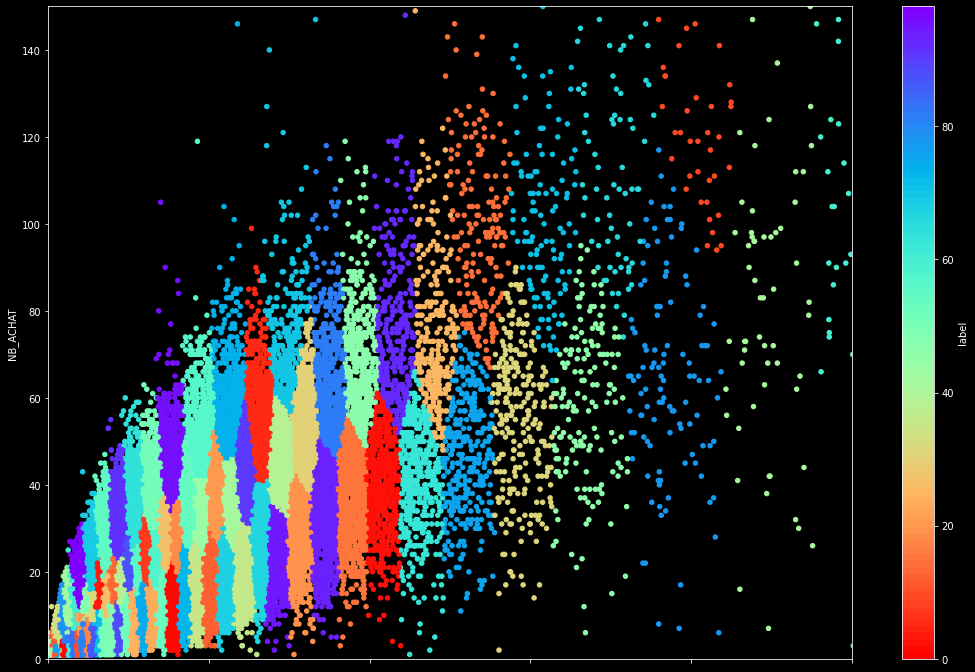

In [12]:
color_map = plt.get_cmap('rainbow', nb_cluster)
reversed_color_map = color_map.reversed()

ax = cart_df.plot.scatter(x="PRIX_NET", y="NB_ACHAT", c="label", colormap=reversed_color_map, figsize=(18,12))

ax.set_xlim([0, 1000])
ax.set_ylim([0, 150])

In [13]:
df_base = df.groupby(["CLI_ID"], as_index=True).sum()\
.reset_index()
df_base["label"] = kmeans.labels_
df_base.head()

,CLI_ID,PRIX_NET,NB_ACHAT,label
0,1490281,18.40,5,79
1,13290776,55.50,9,32
2,20163348,7.45,1,11
3,20200041,6.70,2,11
4,20561854,7.05,3,11


In [14]:
client_profile = df_base.loc[df_base.CLI_ID == clientId, ["PRIX_NET", 'NB_ACHAT', "CLI_ID"]].set_index("CLI_ID")
client_profile["label"] = kmeans.predict(client_profile.filter(["PRIX_NET", 'NB_ACHAT']).values)[0]
client_profile

,PRIX_NET,NB_ACHAT,label
CLI_ID,,,
1490281,18.4,5,79


In [15]:
clientsSelected = df_base[(df_base["label"] == client_profile.iloc[0, 2]) & (df_base["CLI_ID"] != clientId)]
clientSelected = clientsSelected[clientsSelected["CLI_ID"] == np.random.choice(clientsSelected["CLI_ID"].ravel())]
clientIdSelected = clientSelected.iloc[0, 0]

In [16]:
clientSelected

,CLI_ID,PRIX_NET,NB_ACHAT,label
599866,991911485,19.05,6,79


In [17]:
client_label = client_profile["label"].values[0]
client_label

79

In [18]:
clientIdSelected

991911485

In [19]:
clientSelected.filter(["PRIX_NET", 'NB_ACHAT', "label"]).values.ravel()

array([19.05,  6.  , 79.  ])

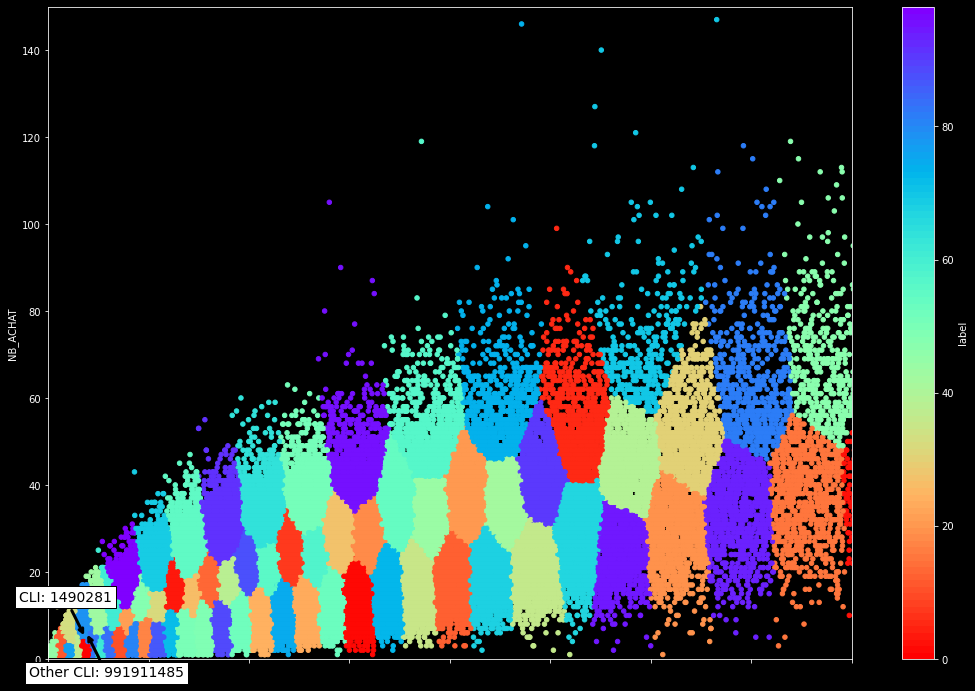

In [20]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
color_map = plt.get_cmap('rainbow', nb_cluster)
reversed_color_map = color_map.reversed()


centroid = kmeans.cluster_centers_[client_label]
ax = df_base.plot.scatter(x="PRIX_NET", y="NB_ACHAT", c="label", colormap=reversed_color_map, figsize=(18,12))

ax.set_xlim([0, 400])
ax.set_ylim([0, 150])



xy = client_profile.drop(["label"], axis=1).values.ravel()
offsetbox = TextArea("CLI: " + str(clientId), textprops=dict(color="black", fontsize=14))

ab = AnnotationBbox(offsetbox, xy,
                    xybox=(-20, 40),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=3, color = "black"))
ax.add_artist(ab)



xy = clientSelected.filter(["PRIX_NET", 'NB_ACHAT']).values.ravel()
offsetbox = TextArea("Other CLI: " + str(clientIdSelected), textprops=dict(color="black", fontsize=14))

ab = AnnotationBbox(offsetbox, xy,
                    xybox=(20, -40),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=3, color = "black"))
ax.add_artist(ab)

# Recommendation de produit

In [23]:
# print(client_profile.reset_index().head(), '\n')
# print(clientSelected.head())
base_product = next(iter(base_df[base_df["CLI_ID"] == clientId]["LIBELLE"].value_counts().to_dict()))
base_product

'GD JDM4 PAMPLEMOUSSE FL 200ML'

### Delete unused columns, drop NAs, create additionnal columns, and only keep TICKET_IDS with multiple product which are not the same.


In [24]:
def preprocessing_df(df):
    df.drop(columns=['MOIS_VENTE', 'PRIX_NET'], axis=1, inplace=True)
    df.dropna(axis='columns')
    encoder = LabelEncoder()
    df['ALL_LIBELLES'] = None
    df['CODE_LIBELLE'] = encoder.fit_transform(df['LIBELLE'])
    df['CODE_LIBELLE'] = df['CODE_LIBELLE'].apply(lambda x: '_'+str(x))
    # Keep only ticket ids with multiple product
    df = df.drop_duplicates()
    single_tickets = df.duplicated(subset='TICKET_ID', keep=False)
    df = df[single_tickets]
    return df

df = preprocessing_df(base_df)

### Separate two dataframes, one for calculating the association rules and the other for looking up the libelles(description) to display on our recommendations


In [25]:
def get_products_orders_df(df):
    orders = df[['TICKET_ID', 'CODE_LIBELLE']]
    products = df[['CODE_LIBELLE', 'LIBELLE']].copy()

    # Drop duplicated products
    products = products[~products.duplicated()]
    products = products[~products.duplicated(subset=['CODE_LIBELLE'])]

    # Set the index to CODE_LIBELLE
    products = products.set_index('CODE_LIBELLE')
    # Convert to Series for easier lookups
    products = products['LIBELLE']
    orders = orders.groupby('TICKET_ID')['CODE_LIBELLE'].apply(list).reset_index()

    return orders, products

orders_df, products_df = get_products_orders_df(df)

### fit the TransactionEncoder and do the transformation


In [26]:
def encode_orders_df(orders_df):
    te = TransactionEncoder()
    orders_1hot = te.fit(orders_df['CODE_LIBELLE']).transform(orders_df['CODE_LIBELLE'])
    orders_1hot = pd.DataFrame(orders_1hot, columns=te.columns_)
    return orders_1hot

orders_1hot = encode_orders_df(orders_df)

In [27]:
%%timeit -n1 -r1

# FPGROWTH METHOD, cf: https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/

# the orders_1hot value should be the return of encode_orders_df function
fpgrowth(orders_1hot, min_support=0.001, max_len=5, use_colnames=True)

36.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [28]:
fp = fpgrowth(orders_1hot, min_support=0.001, max_len=5, use_colnames=True)
fp

,support,itemsets
0,0.007102,(_733)
1,0.002401,(_29)
2,0.001738,(_469)
3,0.002097,(_1279)
4,0.006841,(_687)
...,...,...
1369,0.001329,"(_707, _859)"
1370,0.001282,"(_270, _707, _859)"
1371,0.001024,"(_1469, _1413)"
1372,0.001124,"(_1448, _1363)"


In [29]:
rules = association_rules(fp, metric="lift", min_threshold=5)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(_742),(_733),0.007436,0.007102,0.001254,0.168648,23.745132,0.001201,1.194317
1,(_733),(_742),0.007102,0.007436,0.001254,0.176562,23.745132,0.001201,1.205391
2,(_1358),(_733),0.008315,0.007102,0.001048,0.125988,17.738715,0.000988,1.136023
3,(_733),(_1358),0.007102,0.008315,0.001048,0.147490,17.738715,0.000988,1.163254
4,(_1344),(_1345),0.014105,0.009621,0.002069,0.146716,15.249597,0.001934,1.160667


In [30]:
def predict(antecedent, rules, max_results=10):
    
    # get the rules for this antecedent
    preds = rules[rules['antecedents'] == antecedent]
    
    # a way to convert a frozen set with one element to string
    preds = preds['consequents'].apply(iter).apply(next)
    
    return preds[:max_results]

code_libelle = next(iter(set(df[df['LIBELLE'] == base_product].CODE_LIBELLE.values)))

preds = predict({code_libelle}, rules)
preds

1809    _729
1839    _726
1845    _729
1947    _731
2007    _725
2009    _726
2011    _732
2013    _728
2015    _727
2021    _726
Name: consequents, dtype: object

In [32]:
print('Original product :', products_df[code_libelle], '\n')

print('Recommended products :')
for stockid in set(preds):  
    print(products_df[stockid])

Original product : GD JDM4 PAMPLEMOUSSE FL 200ML 

Recommended products :
GD JDM4 TIARE FL 200ML
GD JDM4 ORANGE FL 200ML
GD JDM4 CIT VERT FL 200ML
GD JDM4 GRENADE FL200ML
GD JDM4 LAVANDIN DE PROVENCE 200ML
GD JDM4 THE VERT FL200ML
GD JDM4 LOTUS FL200ML
